# Linear Regression Bike Availability Example
This notebook demonstrates a simple linear regression approach to forecasting bike availability.

## Data Loading and Inspection

We load the dataset and set the date-time column (`last_reported`) as the index for efficient time series analysis.

In [9]:
# Data Loading and Inspection
import pandas as pd

data = pd.read_csv("final_merged_data.csv", parse_dates=['last_reported'])
data.set_index('last_reported', inplace=True)

# Verify data loading and index
print(data.head())

                     station_id  num_bikes_available  num_docks_available  \
last_reported                                                               
2024-12-01 00:10:00          10                   15                    1   
2024-12-01 00:10:00         100                   17                    8   
2024-12-01 00:10:00         109                   20                    9   
2024-12-01 00:10:00          11                    1                   29   
2024-12-01 00:10:00         114                    4                   36   

                     is_installed  is_renting  is_returning  \
last_reported                                                 
2024-12-01 00:10:00          True        True          True   
2024-12-01 00:10:00          True        True          True   
2024-12-01 00:10:00          True        True          True   
2024-12-01 00:10:00          True        True          True   
2024-12-01 00:10:00          True        True          True   

                  

## Exploratory Data Analysis (EDA)

Here, we examine the trends of bike availability over time at a specific station (e.g., station ID 10). We aggregate the data hourly and visualize bike availability patterns.

C:\Users\neasa\AppData\Local\Temp\ipykernel_14216\1830691531.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  station_data['num_bikes_available'].resample('1H').mean().plot(figsize=(10,4))


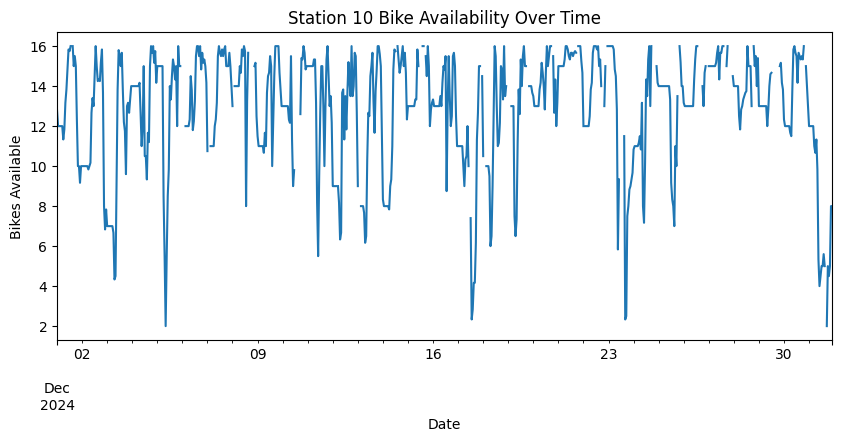

In [10]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt

station_id = 10
station_data = data[data.station_id == station_id]

# Resample and plot hourly average bike availability
station_data['num_bikes_available'].resample('1H').mean().plot(figsize=(10,4))

plt.title(f'Station {station_id} Bike Availability Over Time')
plt.ylabel('Bikes Available')
plt.xlabel('Date')
plt.show()



## Feature Engineering

We generate new features to help our model understand daily and hourly cycles. Features include cyclical encoding for hours of the day and a lag feature representing the previous hour's bike availability.

In [11]:
# Example feature generation code 
import numpy as np

# Select numeric columns only
station_hourly = station_data[['num_bikes_available', 'num_docks_available']].resample('1h').mean()

# Now, create additional features safely
station_hourly['hour'] = station_hourly.index.hour
station_hourly['dow'] = station_hourly.index.dayofweek
station_hourly['hour_sin'] = np.sin(2 * np.pi * station_hourly['hour'] / 24)
station_hourly['hour_cos'] = np.cos(2 * np.pi * station_hourly['hour'] / 24)
station_hourly['lag1'] = station_hourly['num_bikes_available'].shift(1)

# Drop rows with NaN values introduced by shifting
station_hourly.dropna(inplace=True)

# View results
station_hourly.head()



num_bikes_available  num_docks_available  hour  dow  \
last_reported                                                              
2024-12-01 01:00:00                 12.0                  4.0     1    6   
2024-12-01 02:00:00                 12.0                  4.0     2    6   
2024-12-01 03:00:00                 12.0                  4.0     3    6   
2024-12-01 04:00:00                 12.0                  4.0     4    6   
2024-12-01 05:00:00                 12.0                  4.0     5    6   

                     hour_sin  hour_cos  lag1  
last_reported                                  
2024-12-01 01:00:00  0.258819  0.965926  12.8  
2024-12-01 02:00:00  0.500000  0.866025  12.0  
2024-12-01 03:00:00  0.707107  0.707107  12.0  
2024-12-01 04:00:00  0.866025  0.500000  12.0  
2024-12-01 05:00:00  0.965926  0.258819  12.0

## Model Training: Linear Regression

We train a Linear Regression model using the engineered features.

In [12]:
from sklearn.linear_model import LinearRegression
features = ['lag1', 'hour_sin', 'hour_cos']  # Add more features as required
X = station_hourly[features]
y = station_hourly['num_bikes_available']

model = LinearRegression().fit(X, y)


## Model Evaluation

Evaluate the Linear Regression model performance using Mean Absolute Error (MAE) and R-squared (R²) metrics.

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score
# Evaluation of the Linear Regression Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Assume station_hourly is your prepared dataset with features and target
features = ['lag1', 'hour_sin', 'hour_cos']  
X = station_hourly[features]
y = station_hourly['num_bikes_available']

# Split the data into training and testing sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffle for time-series data
)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.82
R² Score: 0.84


## Saving the Trained Model

Save the trained model to disk using Joblib for later use, such as in a Flask web application for predictions.

In [14]:
import joblib
joblib.dump(model, 'linear_regression_bikes_model.pkl')

['linear_regression_bikes_model.pkl']

## How to Access:

- Run your Flask app, then open in a web browser:
- http://localhost:5000/predictor_demo
- Input the Station ID (e.g., 10) and select a datetime.
- Click "Predict Availability". 
- You'll clearly see predicted bike availability returned from your Flask endpoint.
- Improve feature engineering by incorporating weather data.

bike-predictor/

├── app.py

├── linear_regression_bikes_model.pkl

└── templates/

    └── predictor_demo.html